# Deploy & Run Stable Diffusion on SageMaker and Inferentia2

**SageMaker Studio Kernel: Data Science (ml.t3.medium)**

Stable Diffusion is a transformer model that generates random images out of textual prompts (description of the scene). You can get more information of the model implementation at: https://github.com/Stability-AI/

This sample shows how to compile & deploy a pre-trained [HF Stable Diffusion 2.1](https://huggingface.co/stabilityai/stable-diffusion-2-1) to [Inferentia2](https://aws.amazon.com/ec2/instance-types/inf2/) using SageMaker. You need to run two steps to complete this task: 1) A SageMaker Training Job using a Trainium instance for compiling the model and; 2) create a SageMaker real-time endpoint, hosted on an Inferentia2 instance, to deploy and invoke your model.

**Compilation:** First you'll kick-off a SageMaker training job on a **trn1.2xlarge** instance. NeuronSDK requires NeuronCore v2 to compile the model. It takes ~24.2mins with a trn1.2xlarge. (Estimated compilation cost on 2023 May 13 - us-west-2 ml.trn1.2xlarge \\$1.54/h ::: 24.2mins=$0.621). You compile the model once and deploy & run as many times as you need.

**Inference:** After compiling the model it is time to deploy. You'll create a SageMaker real-time Endpoint hosted on an **inf2** instance. SageMaker exposes your model as a webservice and allow you to invoke it with a simple API call.


The compilation mechanism supports datatypes in FP32 or BF16. BF16 will give you a lower latency and it is selected by default.

## 1) Install some dependencies

In [ ]:
%pip install -U sagemaker

## 2) Initialize variables
Not all regions have trn1 and inf2 instances available at the time this notebook was published. us-east-1 has trn1 instances and us-east-2 has inf2 instances. That way, we need to create two sagemaker sessions: 1/ for compiling the model (us-east-1); 2/ for deploying the model (us-east-2).

In [ ]:
import boto3
import sagemaker
import numpy as np

print(sagemaker.__version__)
if not sagemaker.__version__ >= "2.146.0": print("You need to upgrade or restart the kernel if you already upgraded")

region_trn1='us-west-2'
boto3_sess_trn1 = boto3.Session(region_name=region_trn1) # trn1 session
sess_trn1 = sagemaker.Session(boto3_sess_trn1)

region_inf2='us-east-2'
boto3_sess_inf2 = boto3.Session(region_name=region_inf2) # inf2 session
sess_inf2 = sagemaker.Session(boto3_sess_inf2)

bucket_trn1 = sess_trn1.default_bucket()
bucket_inf2 = sess_inf2.default_bucket()
role = sagemaker.get_execution_role()

# https://github.com/aws/deep-learning-containers/blob/master/available_images.md#neuron-containers
train_image_name="pytorch-training-neuronx"
inference_image_name="pytorch-inference-neuronx"
# We need SDK2.10+ to deal with SDs
image_tag="1.13.1-neuronx-py38-sdk2.10.0-ubuntu20.04"

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket trn1: {bucket_trn1}")
print(f"sagemaker bucket trn1: {bucket_inf2}")
print(f"sagemaker session regions. trn1: {region_trn1} inf2: {region_inf2}")

## 3) Visualize scripts
We have 3 scripts that will do the job. 
  - src/wrapper.py: Helper class created to wrap the model and expose the parts that we will compile to inf2. It is also a way to put everything back together to compose a pipeline.
  - src/compile.py: NeuronSDK compilation script that makes use of the wrapper, splits the model into 4 parts and compile each one individually.
  - src/inference.py: SageMaker inference script that also makes use of wrapper to reload the compiled parts and re-build the pipeline responsible for getting the predictions.

In [ ]:
!pygmentize src/wrapper.py

In [ ]:
!pygmentize src/compile.py

In [ ]:
!pygmentize src/inference.py

## 4) Compile the model

In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="compile.py", # Specify your train script
    source_dir="src",
    image_uri=f"763104351884.dkr.ecr.{region_trn1}.amazonaws.com/{train_image_name}:{image_tag}",
    role=role,
    sagemaker_session=sess_trn1,
    instance_count=1,
    instance_type='ml.trn1.2xlarge',
    disable_profiler=True,
    output_path=f"s3://{bucket_trn1}/output",    
    volume_size = 384,
    
    # Parameters required to enable checkpointing
    # This is necessary for caching XLA HLO files and reduce training time next time    
    checkpoint_s3_uri=f"s3://{bucket_trn1}/checkpoints",
    hyperparameters={
        "dtype": "bf16" # dtype can also be fp32
    }
)
estimator.framework_version = '1.13.1' # workround when using image_uri
estimator._is_compiled_model = True

In [ ]:
# it takes around 1452 seconds to complete the job on a trn1.2xlarge
# You will run this just once to compile the model.
estimator.fit()

## 5) Deploy the model to inferentia2
We compiled the model in one region but we'll deploy to another region. So, we need to copy the models artifacts first and then create a PyTorchModel

In [ ]:
import boto3
s3 = boto3.resource('s3', region_name=region_trn1)

model_name="stable-diffusion-neuron-inferentia"
model_data=f"s3://{sess_inf2.default_bucket()}/{model_name}/model.tar.gz"
copy_source = {
    'Bucket': sess_trn1.default_bucket(),
    'Key': estimator.model_data.split('/', 3)[-1]
}
s3.meta.client.copy(copy_source, sess_inf2.default_bucket(), f'{model_name}/model.tar.gz')

In [ ]:
import logging
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.utils import name_from_base

# depending on the inf2 instance you deploy the model you'll have more or less accelerators
# we'll ask SageMaker to launch 1 worker per accelerator

instance_type_idx=2 # default ml.inf2.24xlarge
instance_types=['ml.inf2.xlarge', 'ml.inf2.8xlarge', 'ml.inf2.24xlarge','ml.inf2.48xlarge']
num_workers=[1,1,6,12]

print(f"Instance type: {instance_types[instance_type_idx]}. Num SM workers: {num_workers[instance_type_idx]}")
pytorch_model = PyTorchModel(
    image_uri=f"763104351884.dkr.ecr.{region_inf2}.amazonaws.com/{inference_image_name}:{image_tag}",
    model_data=model_data,
    role=role,    
    name=name_from_base('sd-inf2'),
    sagemaker_session=sess_inf2,
    container_log_level=logging.DEBUG,
    model_server_workers=num_workers[instance_type_idx], # 1 worker per inferentia chip
    framework_version="1.13.1",
    env = {
        'SAGEMAKER_MODEL_SERVER_TIMEOUT' : '3600' 
    }
    # for production it is important to define vpc_config and use a vpc_endpoint
    #vpc_config={
    #    'Subnets': ['<SUBNET1>', '<SUBNET2>'],
    #    'SecurityGroupIds': ['<SECURITYGROUP1>', '<DEFAULTSECURITYGROUP>']
    #}
)
pytorch_model._is_compiled_model = True

In [ ]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type=instance_types[instance_type_idx],
    model_data_download_timeout=3600, # it takes some time to download all the artifacts and load the model
    container_startup_health_check_timeout=1800
)

## 6) Run a simple test

In [ ]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import BytesDeserializer
predictor.serializer = JSONSerializer()
predictor.deserializer = BytesDeserializer(accept='image/jpeg')

The model latency per prediction in BF16 is ~2.01s (50 iterations) ~1.08s (25 iterations).
The time you'll get here also includes IO (data transfer in and out). You can reduce that by defining a VPC-endpoint in the PyTorchModel above.
6 images generated in 1.22s.


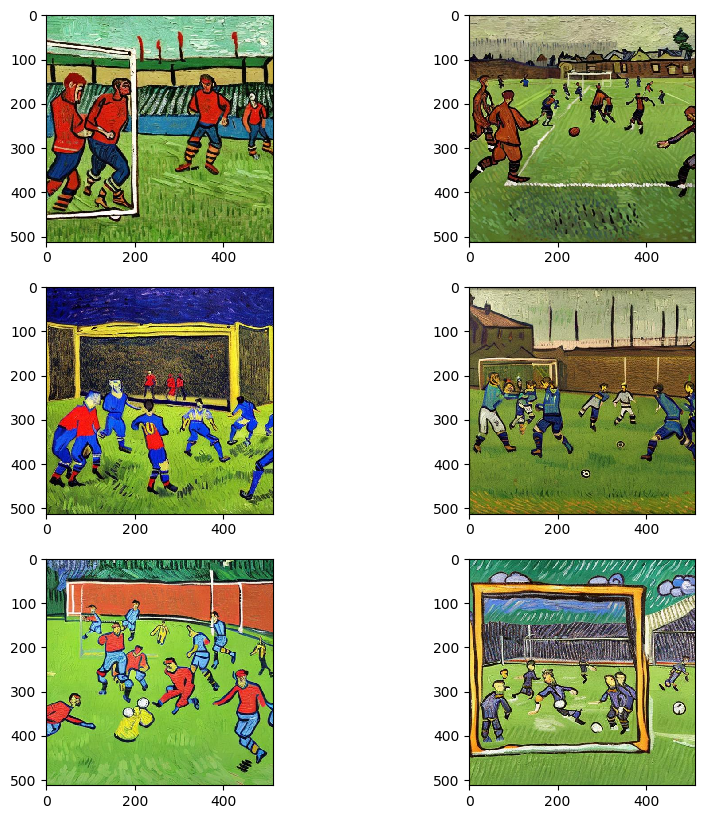

In [10]:
%matplotlib inline
import io
import time
import matplotlib.pyplot as plt
from PIL import Image
from multiprocessing.pool import ThreadPool

# adjust this number according to the instance size and number of workers
num_clients = num_workers[instance_type_idx]
input_req={
    "prompt": "football match; van gogh style",
    # more info about these 2 params here: https://huggingface.co/blog/stable_diffusion
    "num_inference_steps": 25,
    "guidance_scale": 7.5
}
input_reqs=[input_req] * num_clients

def predict(req):    
    data = predictor.predict(req)
    return data

print("The model latency per prediction in BF16 is ~2.01s (50 iterations) ~1.08s (25 iterations).")
print("The time you'll get here also includes IO (data transfer in and out). You can reduce that by defining a VPC-endpoint in the PyTorchModel above.")
with ThreadPool(num_clients) as p:
    t=time.time()
    data = p.map(predict, input_reqs)
    print(f"{len(data)} images generated in {(time.time()-t):0.2f}s.")

fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 3
j=0
for i in range(1, columns*rows +1):    
    fig.add_subplot(rows, columns, i)
    plt.imshow(Image.open(io.BytesIO(data[j])))
    j += 1
plt.show()

### Delete the endpoint (manually or scheduled)

In [ ]:
import time

last_cell_timestamp = time.time()

If you're running the notebook with "Run All Cells" command, the above cell and the below cell will be executed automatically one by one and the endpoint will stay active for you to experiment with. It will incur additional hourly charges.

However, if you run the below cell manually again after some time depending on the `grace_period_seconds` variable, the endpoint will be gracefully deleted and no further charges will occur.

If you forget to delete the endpoint manually, but will keep the notebook kernel instance up and running, the endpoint will be deleted by the background thread depending on the `auto_delete_hours` variable.

In [ ]:
import threading
import botocore.exceptions

seconds_since_last_cell_timestamp = int(time.time() - last_cell_timestamp)
grace_period_seconds = 30
auto_delete_hours = 4.0

def delete_endpoint():
    try:
        predictor.delete_endpoint(delete_endpoint_config=False)
    except botocore.exceptions.ClientError as e:
        # Most likely, already deleted
        print(e)
        pass
    print("Endpoint has been deleted.")
    
def schedule_auto_delete():
    global auto_delete_timer
    try:
        print("Cancelling previous timer...")
        auto_delete_timer.cancel()
    except NameError:
        print("Timer hasn't been yet defined.")
        print(f"Scheduling the automatic deletion in {auto_delete_hours} hours.")
    else:
        print("Timer is cancelled.")
        print(f"Re-scheduling the automatic deletion in {auto_delete_hours} hours.")
    auto_delete_timer = threading.Timer(auto_delete_hours * 60 * 60, delete_endpoint)
    auto_delete_timer.start()    

print("Checking notebook for automated run...")
print(f"Seconds since last cell exectution: {seconds_since_last_cell_timestamp}")
if seconds_since_last_cell_timestamp > grace_period_seconds:
    print("Cell is executed manually. Deleting endpoint.")
    delete_endpoint()
else:
    print("Cell is executed automatically. Skipping endpoint delete. Don't forget to run the cell again to delete endpoint manually.")
    schedule_auto_delete()

If you don't want to delete the endpoint right now, but want to extend the automatic deletion instead, run the below cell manually. The countdown for automatic deletion will start over.

In [ ]:
seconds_since_last_cell_timestamp = int(time.time() - last_cell_timestamp)
print(f"Seconds since last cell exectution: {seconds_since_last_cell_timestamp}")

if seconds_since_last_cell_timestamp > grace_period_seconds:
    print(f"Cell is executed manually. Re-scheduling the timer.")
    schedule_auto_delete()
else:
    print("Cell is executed automatically. Skipping re-scheduling. Run the cell again to re-schedule deletion.")